# Importing Libraries

In [1]:
from shapely.geometry import Point, LineString, shape
import matplotlib.pyplot as plt # Importing Libraries
import geopandas as gpd
import contextily as ctx
import pandas as pd
import numpy as np

In [2]:
import os, sys
sys.path.append(os.path.join(os.path.expanduser('~'), 'Documents/Insert-Generic-Name-Here/'))
# sys.path

from lonelyboy.geospatial import plots as gsplt
from lonelyboy.geospatial import preprocessing as gspp
from lonelyboy.timeseries import lbtimeseries as tspp
from lonelyboy.geospatial import group_patterns_v2 as gsgp

get_ipython().magic('matplotlib qt')
# get_ipython().magic('matplotlib inline')

# params = {"ytick.color" : "steelblue",
#           "xtick.color" : "steelblue",
#           "axes.labelcolor" : "steelblue",
#           "axes.edgecolor" : "steelblue"}

In [3]:
PLT_FIG_WIDTH = 10.487
PLT_FIG_HEIGHT = PLT_FIG_WIDTH / 1.618

## Get & Plot a Random Vessel's Trajectory

In [23]:
%%time
# mmsis tested: 305166000, 228037600, 205067000, 227519920
csv_iter = gspp.read_csv_generator('data/csv/nari_dynamic.csv')
traj = pd.concat((chunk[chunk['mmsi'] == 227519920] for chunk in csv_iter), ignore_index=True)
traj = gspp.gdf_from_df(traj, crs={'init':'epsg:4326'})

# Preprocess Trajectory
traj.drop_duplicates(subset=['mmsi', 'ts'], inplace=True)
traj['datetime'] = pd.to_datetime(traj['ts'], unit='s')
traj.sort_values('ts', inplace=True)
traj.reset_index(inplace=True, drop=True)
traj.head()

CPU times: user 11.7 s, sys: 491 ms, total: 12.2 s
Wall time: 12.3 s


In [5]:
ports = pd.read_pickle('data/pkl/ports_raw.pkl')
ports.head()

,gid,gml_id,por_id,libelle_po,insee_comm,por_x,por_y,geom
0,1,port.1,1,Le Vivier-sur-Mer,35361,297025.0,2408370.0,POINT (-1.771798868659233 48.60274269672541)
1,2,port.10,10,Saint-Samson sur Rance,22327,279335.0,2396060.0,POINT (-2.001990119062326 48.48369993456267)
2,3,port.100,100,Douarnenez,29046,103135.0,2365330.0,POINT (-4.341204251638414 48.09709590770091)
3,4,port.101,101,Brézellec,29028,79105.4,2364190.0,POINT (-4.661115947908725 48.06804110561076)
4,5,port.102,102,Sein,29083,64562.5,2362180.0,POINT (-4.852944548180974 48.03825273921113)


# Plot the Dataset 
* ### Plot the raw GPS data points
##### (for presentation purposes we plot - and test - only for one ramdomly selected vessel at a time)

* ### Plot the Port's GPS Coordinates

In [6]:
gsplt.map_plot(traj, column='datetime', figsize=(10,15), title="A Vessel's 'raw' trajectory", fontsize=10, color=[None], legend=True)  

In [8]:
gsplt.map_plot(ports, figsize=(10, 10), title="Port Locations", fontsize=10, color=['steelblue'])

### Calculating each Point's Distance from the nearest port 
* #### \w Brute Force 
* #### \w R-Tree Spatial Index

In [6]:
ports2 = ports.copy()
ports2['geom'] = ports.geom.to_crs(epsg=3310).buffer(2000).to_crs(epsg=4326)

ax = ports2.to_crs(epsg=3857).plot(figsize=(15,15))
ax.set_title('Port Locations (with 2km radius)', fontsize=10)
ctx.add_basemap(ax)

In [24]:
%%time
sindex = traj.sindex

# find the points that intersect with each subpolygon and add them to points_within_geometry
points_within_geometry = pd.DataFrame()
for poly in ports2.geom:
    # find approximate matches with r-tree, then precise matches from those approximate ones
    possible_matches_index = list(sindex.intersection(poly.bounds))
    possible_matches = traj.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(poly)]
    points_within_geometry = points_within_geometry.append(precise_matches)
    
points_within_geometry = points_within_geometry.drop_duplicates(subset=['mmsi', 'ts'])
points_outside_geometry = traj[~traj.isin(points_within_geometry)].dropna(how='all')

CPU times: user 743 ms, sys: 7.24 ms, total: 750 ms
Wall time: 749 ms


In [11]:
gsplt.map_plot(points_within_geometry, points_outside_geometry, color=['r','steelblue'], title='Points Outside/Inside Port Radius', fontsize=10)

In [25]:
gsplt.map_plot(traj, ports2, color=['r','steelblue'], title='Points Outside/Inside Port Radius', fontsize=10)

## Now let's compare that approach to the Brute-Force one

In [40]:
%%time
ports_epsg_3310 = ports.to_crs(epsg=3310,inplace=False)
pnt_port_dist = traj.to_crs(epsg=3310,inplace=False).apply(lambda row: gspp.distance_to_nearest_port(row.geom, ports_epsg_3310), axis=1)*0.539956803

CPU times: user 2.66 s, sys: 0 ns, total: 2.66 s
Wall time: 2.66 s


### __Benchmark Results__: ~3 seconds (BF) vs. ~550 milli-seconds (RT). Clearly R-Tree Spatial Index Search is the Best Approach for Large Datasets.

### Now, let's move on to the real Trajectory Segmentation Stage.

### From the R-Trees Result, we have Two DataFrames:
  *  #### Inside the Port (WithinGeometry DF)
  *  #### Outside the Port (OutsideGeometry DF)

### Our target, use these to segment the Trajectory into several sub-trajectories

In [25]:
traj['traj_id'] = np.nan
traj.loc[traj.index.isin(points_within_geometry.index), 'traj_id'] = -1
traj.loc[traj.index.isin(points_outside_geometry.index), 'traj_id'] = 0
traj.head()

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id
0,227519920,NaN,NaN,0.0,125.3,511,-4.488679,48.378735,1443689765,POINT (-4.488678500000001 48.378735),2015-10-01 08:56:05,-1.0
1,227519920,NaN,NaN,3.3,249.7,511,-4.490099,48.377872,1443690094,POINT (-4.4900985 48.377872),2015-10-01 09:01:34,-1.0
2,227519920,NaN,NaN,3.7,177.9,511,-4.490875,48.376045,1443690244,POINT (-4.490875 48.376045),2015-10-01 09:04:04,-1.0
3,227519920,NaN,NaN,2.0,77.9,511,-4.489357,48.376220,1443690394,POINT (-4.4893565 48.37622),2015-10-01 09:06:34,-1.0
4,227519920,NaN,NaN,5.6,172.9,511,-4.488760,48.375366,1443690455,POINT (-4.48876 48.375366),2015-10-01 09:07:35,-1.0


In [9]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title('Raw Trajectory Time Plot')
traj.ts.plot(color='c')
trajcp = traj.loc[traj.traj_id[traj.traj_id.replace(-1,np.nan).ffill(limit=1).bfill(limit=1).notnull()].index]
trajcp.loc[trajcp.traj_id==-1].ts.plot(color='m')
plt.subplot(1,3,2)
plt.title('Raw Trajectory ID Plot (-1/0: Inside/Outside Port)')
plt.plot(traj.traj_id.values)
plt.subplot(1,3,3)
tmp = traj.traj_id.diff().dropna()
plt.title('Raw Trajectory ID Delta Plot (Spikes: Port Entrance/Exit)')
plt.plot(tmp.values)

# break_points = tmp.loc[tmp!=0].index
# print(break_points)
# traj.iloc[break_points]

In [26]:
traj['label'] = traj['traj_id']
traj = traj.loc[traj.traj_id[traj.traj_id.replace(-1,np.nan).ffill(limit=1).bfill(limit=1).notnull()].index]

In [27]:
traj.reset_index(inplace=True, drop=True)
traj.head()

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id,label
0,227519920,NaN,NaN,5.5,180.3,511,-4.488140,48.369720,1443690665,POINT (-4.48814 48.36972),2015-10-01 09:11:05,-1.0,-1.0
1,227519920,NaN,NaN,5.9,194.3,511,-4.488643,48.366440,1443690785,POINT (-4.488643 48.36644),2015-10-01 09:13:05,0.0,0.0
2,227519920,NaN,NaN,7.3,207.7,511,-4.494473,48.358850,1443691084,POINT (-4.4944735 48.35885),2015-10-01 09:18:04,0.0,0.0
3,227519920,NaN,NaN,7.2,208.0,511,-4.495968,48.357006,1443691145,POINT (-4.495968299999999 48.357006),2015-10-01 09:19:05,0.0,0.0
4,227519920,NaN,NaN,7.5,208.1,511,-4.496809,48.355980,1443691179,POINT (-4.4968085 48.35598),2015-10-01 09:19:39,0.0,0.0


In [12]:
gsplt.map_plot(ports2, traj.iloc[1000:1030,:], figsize=(10, 10), title="Trajectory on Port Entrance/Exit", fontsize=10, color=['red', 'steelblue'])

In [34]:
print(traj.loc[traj.traj_id == -1].index)
dfs = np.split(traj, traj.loc[traj.traj_id == -1].index)

Int64Index([   0,  127,  128,  199,  200,  222,  223,  238,  239,  242,  286,
             287,  318,  319,  422,  495,  496,  537,  590,  591,  620,  621,
             704,  705,  771,  772,  818,  819,  866,  867,  892,  893,  968,
             969,  973,  974,  978,  979,  995,  996, 1031, 1032, 1100, 1101,
            1171, 1172, 1238, 1239, 1299, 1300, 1403, 1404, 1428],
           dtype='int64')


In [35]:
dfs = [df for df in dfs if len(df) != 0]
# dfs = [df for df in dfs if len(df) >= 3] # test this condition
dfs[0].loc[:,'traj_id'] = 0    # ensure that the points in the first segments have the starting ID (0)

for i in range(1,len(dfs)):        
    if (len(dfs[i]) == 1):
#         print (i, 'here')
        dfs[i].loc[:,'traj_id'] = dfs[i-1].traj_id.max()
# 		dfs[i].loc[:,'traj_id'] = dfs[i].traj_id.apply(lambda x: dfs[i-1].traj_id.max())
    else:
        dfs[i].loc[:,'traj_id'] = dfs[i-1].traj_id.max()+1
# 		dfs[i].loc[:,'traj_id'] = dfs[i].traj_id.apply(lambda x: x+dfs[i-1].traj_id.max()+1)
            

df_fn = pd.concat(dfs)
df_fn.sort_values('ts', inplace=True)
df_fn.reset_index(inplace=True, drop=True)

In [36]:
df_fn.traj_id.unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27.])

In [73]:
gsplt.map_plot(df_fn, column='traj_id', color=[None], cmap='tab20', title="Trajectory Segments", fontsize=10, legend=True)

In [37]:
df_fn.loc[df_fn.traj_id == 1]

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id,label
128,227519920,NaN,NaN,7.5,166.4,511,-4.487225,48.367054,1443876060,POINT (-4.487225 48.367054),2015-10-03 12:41:00,1.0,-1.0
129,227519920,NaN,NaN,6.4,197.9,511,-4.488390,48.361813,1443876238,POINT (-4.48839 48.361813),2015-10-03 12:43:58,1.0,0.0
130,227519920,NaN,NaN,6.0,200.0,511,-4.491260,48.356820,1443876419,POINT (-4.49126 48.35682),2015-10-03 12:46:59,1.0,0.0
131,227519920,NaN,NaN,5.7,204.1,511,-4.492476,48.354553,1443876508,POINT (-4.4924765 48.354553),2015-10-03 12:48:28,1.0,0.0
132,227519920,NaN,NaN,5.5,199.0,511,-4.493402,48.353140,1443876569,POINT (-4.4934015 48.35314),2015-10-03 12:49:29,1.0,0.0
133,227519920,NaN,NaN,4.8,192.3,511,-4.495350,48.348755,1443876748,POINT (-4.49535 48.348755),2015-10-03 12:52:28,1.0,0.0
134,227519920,NaN,NaN,2.8,160.1,511,-4.494635,48.345560,1443876928,POINT (-4.494635 48.34556),2015-10-03 12:55:28,1.0,0.0
135,227519920,NaN,NaN,2.2,158.3,511,-4.494137,48.344585,1443877018,POINT (-4.494137 48.344585),2015-10-03 12:56:58,1.0,0.0
136,227519920,NaN,NaN,4.1,157.1,511,-4.493548,48.343513,1443877109,POINT (-4.493548400000001 48.343513),2015-10-03 12:58:29,1.0,0.0
137,227519920,NaN,NaN,5.5,141.4,511,-4.490563,48.340540,1443877259,POINT (-4.490563400000001 48.34054),2015-10-03 13:00:59,1.0,0.0


## Now that we have our Trajectories, it's time to:
  * #### Resample each Sub-Trajectory
  * #### Use our Implementation on Trajectory Segmentation in order to associate each subtrajectory with an activity

In [84]:
resampled_traj = []
for traj_id in df_fn.traj_id.unique():
    sub_traj = df_fn.loc[df_fn.traj_id == traj_id]
    resampled_traj.append(gspp.resample_geospatial(sub_traj))
    
resampled_traj = pd.concat((sub_traj for sub_traj in resampled_traj), ignore_index=True)

/home/andretri7/Documents/Insert-Generic-Name-Here/lonelyboy/geospatial/preprocessing.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  vessel['datetime'] = pd.to_datetime(vessel['ts'], unit='s')


In [86]:
gsplt.map_plot(resampled_traj, column='traj_id', color=[None], cmap='tab20', title="Trajectory Segments (Resampled)", fontsize=10, legend=True)

In [87]:
tagged_traj = []
for traj_id in resampled_traj.traj_id.unique():
    sub_traj = resampled_traj.loc[resampled_traj.traj_id == traj_id]
    sub_traj = gspp.calculate_velocity(sub_traj, smoothing=False, window=15, center=False)
    sub_traj_tagged = gspp._segment_vessel(sub_traj.copy(), None, pois_alpha=-1, pois_window=100, semantic=False)
    sub_traj['sub_traj_id'] = sub_traj_tagged.traj_id.values
    tagged_traj.append(sub_traj)
    
tagged_traj = pd.concat((sub_traj for sub_traj in tagged_traj), ignore_index=True)

/home/andretri7/Documents/Insert-Generic-Name-Here/lonelyboy/geospatial/preprocessing.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['current_loc'] = gdf.geom.apply(lambda x: (x.x,x.y))
/home/andretri7/Documents/Insert-Generic-Name-Here/lonelyboy/geospatial/preprocessing.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  gdf['next_loc'] = gdf.geom.shift(-1)
/home/andretri7/anaconda3/envs/gis/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [88]:
gsplt.map_plot(tagged_traj, column='sub_traj_id', color=[None], title="Trajectory Segments (Resampled & Tagged)", fontsize=10, cmap='tab20', legend=True)

## Now to Create our Segmentation Pipeline:

  * ### First segment based on this notebook's method

In [12]:
%%time
# vessel_fn = gspp.segment_resample_and_tag_v2(traj, ports)
vessel_fn = gspp.segment_trajectories_v2(traj, ports)

CPU times: user 885 ms, sys: 7.68 ms, total: 893 ms
Wall time: 888 ms


  * ### [Intermediate-Step-1] Plot the First Segmentation's Result

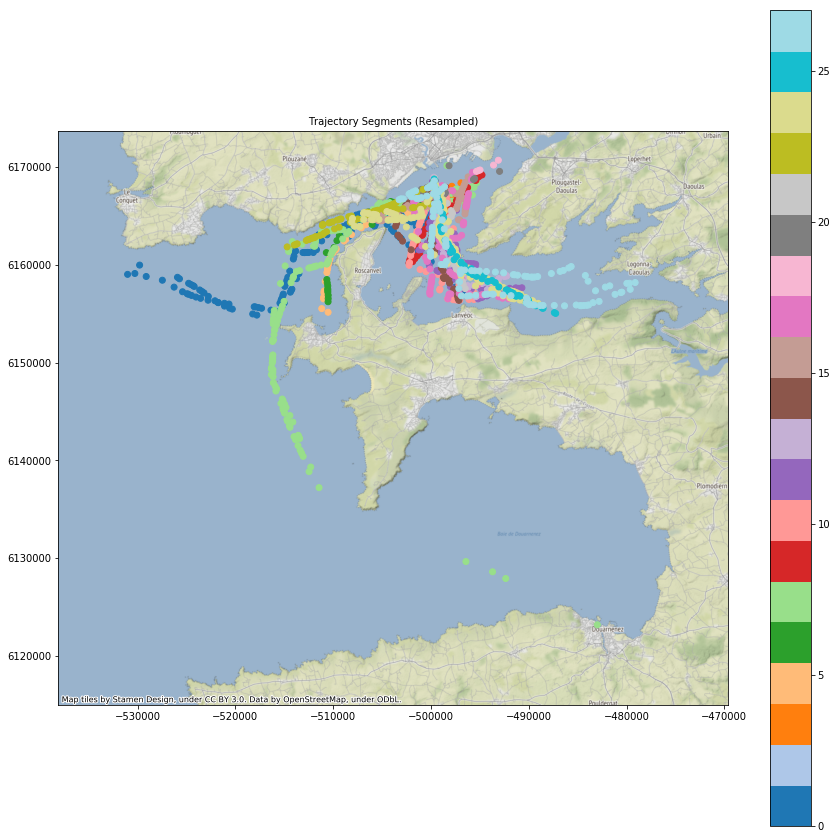

In [12]:
gsplt.map_plot(vessel_fn, column='traj_id', color=[None], cmap='tab20', title="Trajectory Segments (Resampled)", fontsize=10, legend=True)

In [13]:
vessel_fn.head()

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id
0,227519920,NaN,NaN,5.5,180.3,511,-4.488140,48.369720,1443690665,POINT (-4.48814 48.36972),2015-10-01 09:11:05,0.0
1,227519920,NaN,NaN,5.9,194.3,511,-4.488643,48.366440,1443690785,POINT (-4.488643 48.36644),2015-10-01 09:13:05,0.0
2,227519920,NaN,NaN,7.3,207.7,511,-4.494473,48.358850,1443691084,POINT (-4.4944735 48.35885),2015-10-01 09:18:04,0.0
3,227519920,NaN,NaN,7.2,208.0,511,-4.495968,48.357006,1443691145,POINT (-4.495968299999999 48.357006),2015-10-01 09:19:05,0.0
4,227519920,NaN,NaN,7.5,208.1,511,-4.496809,48.355980,1443691179,POINT (-4.4968085 48.35598),2015-10-01 09:19:39,0.0


* ### Then segment based on temporal difference (>12h per segment)

In [13]:
print(f"Segments Before: {len(vessel_fn.traj_id.unique())}")
vessel_fn['traj_id_12h_gap'] = 0
vessel_fn.sort_values(['ts'], inplace=True)
pre_segment_threshold = 12 # in hrs

dfs_temporal = []

for traj_id, sdf in vessel_fn.groupby('traj_id'):
    df = sdf.reset_index()
    break_points = df.ts.diff(-1).abs().index[df.ts.diff()>60*60*pre_segment_threshold]
    
    if (len(break_points) > 0):
        dfs = np.split(df, break_points)
    else:
        dfs = [df]
        
    dfs_temporal.extend(dfs)
    #NOTE #1: Check np.split if break_points=[], returns traj
    #NOTE #2: len(df) >= 2

dfs_temporal = [tmp_df for tmp_df in dfs_temporal if len(tmp_df) >= 2]
print(f"Segments After: {len(dfs_temporal)}")

Segments Before: 28
Segments After: 28


  * ### [Intermediate-Step-2] Fix the traj_id (because the second semgentation may create more subtrajectories)

In [14]:
dfs = dfs_temporal
dfs[0].loc[:,'traj_id_12h_gap'] = 0
for idx in range(1, len(dfs)):
    dfs[idx].loc[:,'traj_id_12h_gap'] = dfs[idx].traj_id_12h_gap.apply(lambda x: x+dfs[idx-1].traj_id_12h_gap.max()+1)

for idx in range(0, len(dfs)):
    dfs[idx] = gspp.resample_geospatial(dfs[idx], rule='60S', method='linear', crs={'init': 'epsg:4326'}, drop_lon_lat=False)

In [15]:
df_fn = pd.concat(dfs, ignore_index=True)
df_fn.sort_values('ts', inplace=True)
df_fn.drop(['index'], axis=1, inplace=True)

In [16]:
df_fn.head()

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id,traj_id_12h_gap,real_point
0,227519920.0,NaN,NaN,5.50,180.30,511.0,-4.488140,48.369720,1.443691e+09,POINT (-4.48814 48.36972),2015-10-01 09:11:00,0.0,0.0,1
1,227519920.0,NaN,NaN,5.70,187.30,511.0,-4.488392,48.368080,1.443691e+09,POINT (-4.488391500000001 48.36808000000001),2015-10-01 09:12:00,0.0,0.0,0
2,227519920.0,NaN,NaN,5.90,194.30,511.0,-4.488643,48.366440,1.443691e+09,POINT (-4.488643 48.36644),2015-10-01 09:13:00,0.0,0.0,1
3,227519920.0,NaN,NaN,6.18,196.98,511.0,-4.489809,48.364922,1.443691e+09,POINT (-4.4898091 48.364922),2015-10-01 09:14:00,0.0,0.0,0
4,227519920.0,NaN,NaN,6.46,199.66,511.0,-4.490975,48.363404,1.443691e+09,POINT (-4.490975199999999 48.363404),2015-10-01 09:15:00,0.0,0.0,0


In [17]:
len(df_fn)

3004

  * ### [Intermediate-Step-3] Plot the Second Segmentation's Result

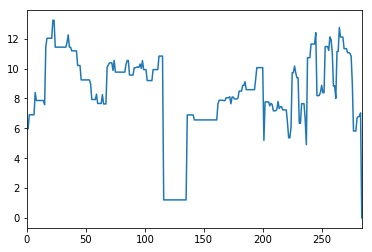

In [65]:
gspp.calculate_velocity(dfs[0], smoothing=False, window=15, center=False)

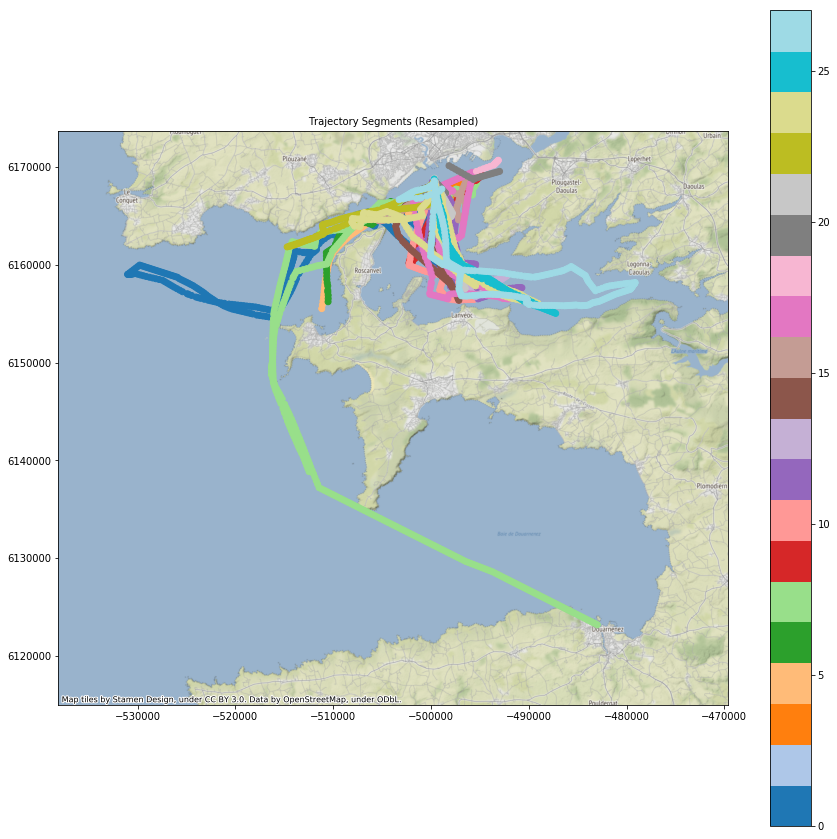

In [273]:
gsplt.map_plot(df_fn, column='traj_id', color=[None], cmap='tab20', title="Trajectory Segments (Resampled)", fontsize=10, legend=True)

  * ### Resample each segment and Use our Implementation to semantically tag each segment

In [18]:
print(np.array([len(tmp) for tmp in dfs]).max())
print(np.array([len(tmp) for tmp in dfs]).min())

294
4


In [19]:
tmp = []
wnd = []

# for traj_id in df_fn.traj_id.unique():
#     sub_traj = df_fn.loc[df_fn.traj_id == traj_id]
#     sub_traj = gspp.calculate_velocity(sub_traj, smoothing=False, window=15, center=False)
#     window = len(sub_traj)//20+1
#     print(window)
#     wnd.extend([window])
#     # TODO: Adjust _segment_vessel function to make use of the status codes (as presented in thesis-tasks doc) as well as the sub_traj_id column
#     # sub_traj_tagged = gspp._segment_vessel(sub_traj.copy(), None, pois_alpha=-1, pois_window=100, semantic=False)
#     sub_traj_tagged = gspp._segment_vessel(sub_traj.copy(), None, pois_alpha=-1, pois_window=100, semantic=False)
#     sub_traj['sub_traj_id'] = sub_traj_tagged.traj_id.values
#     tmp.append(sub_traj)
    
for sub_traj in dfs:
    sub_traj = gspp.calculate_velocity(sub_traj, smoothing=False, window=15, center=False)
    # TODO: Adjust _segment_vessel function to make use of the status codes (as presented in thesis-tasks doc) as well as the sub_traj_id column
    window = len(sub_traj)//20+1
    print(window, end=' ')
    wnd.extend([window])
    
    sub_traj_tagged = gspp._segment_vessel(sub_traj.copy(), None, pois_alpha=-1, pois_window=window, semantic=False)
    sub_traj['sub_traj_id'] = sub_traj_tagged.traj_id.values
    tmp.append(sub_traj)

15 8 2 3 1 5 4 15 8 4 6 6 8 6 5 5 2 8 1 2 4 5 6 7 6 6 13 2 

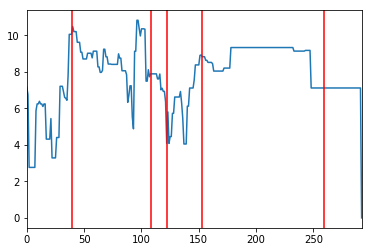

In [318]:
i=7
tmp[i].velocity.plot()

indices = tmp[i].sub_traj_id.diff().loc[tmp[i].sub_traj_id.diff()==1].index
[plt.axvline(point, color='red') for point in indices];

  * ### [Intermediate-Step-4] Fix the sub_traj_id (because the same IDs repeat through each segment)

In [20]:
for idx in range(1, len(tmp)):
    tmp[idx].loc[:,'sub_traj_id'] = tmp[idx].sub_traj_id.apply(lambda x: x+tmp[idx-1].sub_traj_id.max()+1)
vessel_fn = pd.concat(tmp, ignore_index=True)

In [21]:
vessel_fn.head()

,index,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id,traj_id_12h_gap,real_point,velocity,sub_traj_id
0,0.0,227519920.0,0.0,0.0,5.50,180.30,511.0,-4.488140,48.369720,1.443691e+09,POINT (-4.48814 48.36972),2015-10-01 09:11:00,0.0,0.0,1,5.959148,0.0
1,0.5,227519920.0,0.0,0.0,5.70,187.30,511.0,-4.488392,48.368080,1.443691e+09,POINT (-4.488391500000001 48.36808000000001),2015-10-01 09:12:00,0.0,0.0,0,5.959146,0.0
2,1.0,227519920.0,0.0,0.0,5.90,194.30,511.0,-4.488643,48.366440,1.443691e+09,POINT (-4.488643 48.36644),2015-10-01 09:13:00,0.0,0.0,1,6.905452,0.0
3,1.2,227519920.0,0.0,0.0,6.18,196.98,511.0,-4.489809,48.364922,1.443691e+09,POINT (-4.4898091 48.364922),2015-10-01 09:14:00,0.0,0.0,0,6.905445,0.0
4,1.4,227519920.0,0.0,0.0,6.46,199.66,511.0,-4.490975,48.363404,1.443691e+09,POINT (-4.490975199999999 48.363404),2015-10-01 09:15:00,0.0,0.0,0,6.905438,0.0


In [22]:
len(vessel_fn)

2976

  * ### [Intermediate-Step-5] Plot the Final Segmentation's Result (both in terms of __traj_id__ and __sub_traj_id__)

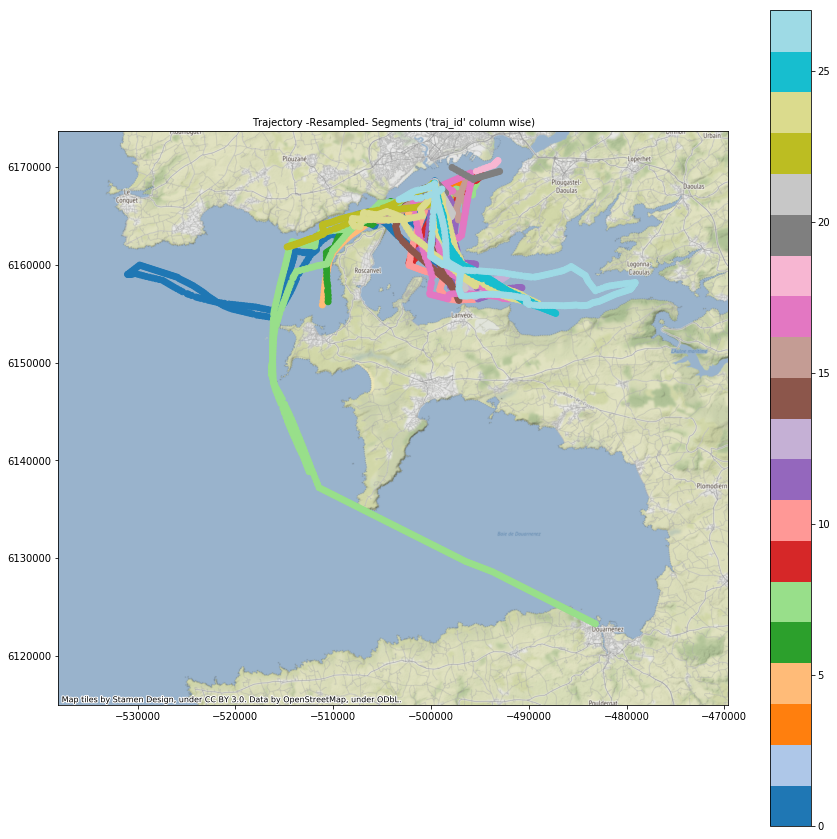

In [278]:
gsplt.map_plot(vessel_fn, column='traj_id', color=[None], cmap='tab20', title="Trajectory -Resampled- Segments ('traj_id' column wise)", fontsize=10, legend=True)

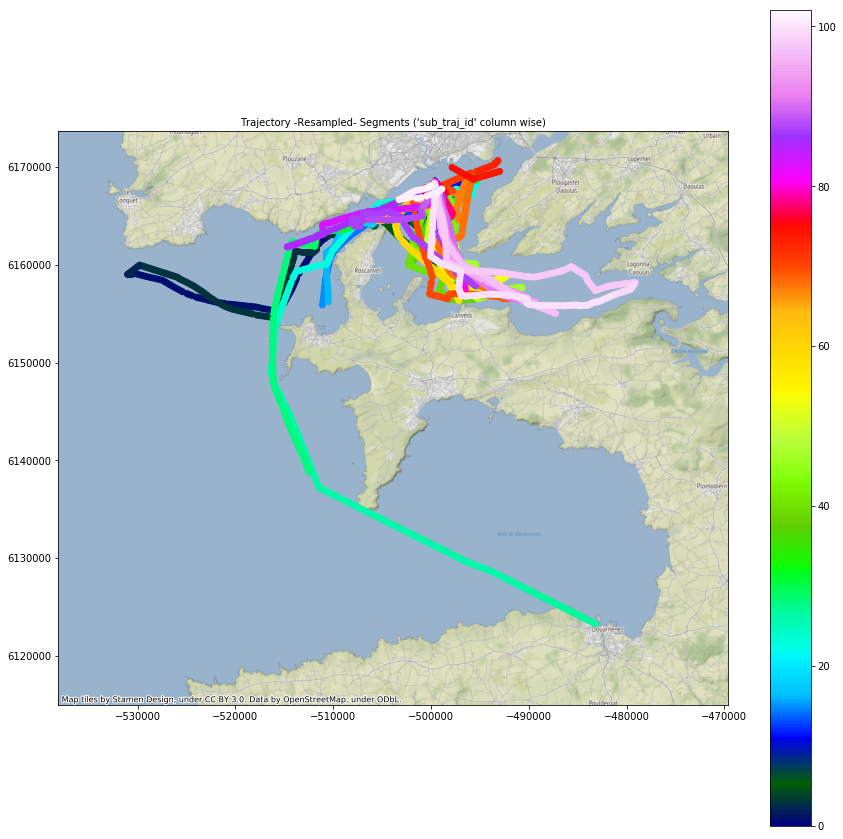

In [285]:
gsplt.map_plot(vessel_fn, column='sub_traj_id', color=[None], cmap='gist_ncar', title="Trajectory -Resampled- Segments ('sub_traj_id' column wise)", fontsize=10, legend=True)

## For Plotting Individual Segments

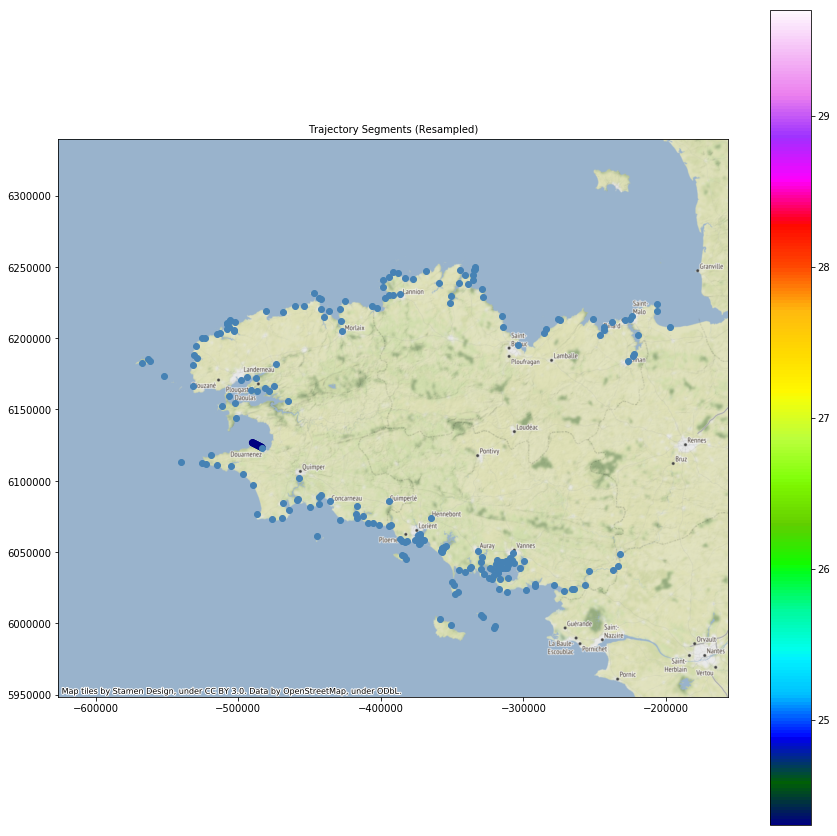

In [261]:
map_plot(vessel_fn.loc[vessel_fn.sub_traj_id==27], ports, column='sub_traj_id', color=[None, 'steelblue'], cmap='gist_ncar', title="Trajectory Segments (Resampled)", fontsize=10, legend=True)

## Testing the Pipeline @lonelyBoy

In [13]:
gsplt.map_plot(traj, column='mmsi', figsize=(PLT_FIG_WIDTH, PLT_FIG_HEIGHT), title="Sample trajectory (mmsi=227519920); Before segmentation.", fontsize=14, color=[None], cmap='tab20', legend=False)  
plt.axis('off')
plt.show()

In [12]:
traj.head()

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime
0,227519920,NaN,NaN,0.0,125.3,511,-4.488679,48.378735,1443689765,POINT (-4.488678500000001 48.378735),2015-10-01 08:56:05
1,227519920,NaN,NaN,3.3,249.7,511,-4.490099,48.377872,1443690094,POINT (-4.4900985 48.377872),2015-10-01 09:01:34
2,227519920,NaN,NaN,3.7,177.9,511,-4.490875,48.376045,1443690244,POINT (-4.490875 48.376045),2015-10-01 09:04:04
3,227519920,NaN,NaN,2.0,77.9,511,-4.489357,48.376220,1443690394,POINT (-4.4893565 48.37622),2015-10-01 09:06:34
4,227519920,NaN,NaN,5.6,172.9,511,-4.488760,48.375366,1443690455,POINT (-4.48876 48.375366),2015-10-01 09:07:35


In [6]:
%%time
vessel_fn = gspp.segment_resample_v2(traj, ports, port_epsg=2154)

Vessel mmsi:227519920
Segments Before: 28
Segments After: 28
CPU times: user 1.29 s, sys: 354 µs, total: 1.29 s
Wall time: 1.29 s


In [13]:
gsplt.map_plot(vessel_fn.loc[(vessel_fn.traj_id_12h_gap==0) & (vessel_fn.real_point==1)], figsize=(PLT_FIG_WIDTH, PLT_FIG_HEIGHT), column='traj_id_12h_gap', color=[None], cmap='tab20', title="Before Resampling", fontsize=14, legend=False)

In [14]:
gsplt.map_plot(vessel_fn.loc[(vessel_fn.traj_id_12h_gap==0)], figsize=(PLT_FIG_WIDTH, PLT_FIG_HEIGHT), column='real_point', color=[None], cmap='tab20', title="After Resampling", fontsize=14, legend=False)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], ls="", marker='o', color=plt.cm.tab20(0.), lw=4),
                Line2D([0], [0], ls="", marker='o', color=plt.cm.tab20(1.), lw=4)]
plt.legend(custom_lines, ['Linearly Interpolated Point', 'Real Point'])
plt.axis('off')
plt.show()

In [12]:
gsplt.map_plot(vessel_fn.loc[vessel_fn.real_point==1], figsize=(PLT_FIG_WIDTH, PLT_FIG_HEIGHT), column='traj_id_12h_gap', color=[None], cmap='tab20', title="Sample trajectory (mmsi=227519920); After segmentation.", fontsize=14, legend=False)
plt.axis('off')
plt.show()

In [11]:
gsplt.map_plot(vessel_fn, figsize=(PLT_FIG_WIDTH, PLT_FIG_HEIGHT), column='traj_id_12h_gap', color=[None], cmap='tab20', title="Sample trajectory (mmsi=227519920); After resampling.", fontsize=14, legend=False)
plt.axis('off')
plt.show()

In [11]:
vessel_fn.head()

,mmsi,status,turn,speed,course,heading,lon,lat,ts,geom,datetime,traj_id,traj_id_12h_gap,real_point,velocity
0,227519920.0,0.0,0.0,5.50,180.30,511.0,-4.488140,48.369720,1.443691e+09,POINT (-4.48814 48.36972),2015-10-01 09:11:00,0.0,0.0,1,5.959148
1,227519920.0,0.0,0.0,5.70,187.30,511.0,-4.488392,48.368080,1.443691e+09,POINT (-4.488391500000001 48.36808000000001),2015-10-01 09:12:00,0.0,0.0,0,5.959146
2,227519920.0,0.0,0.0,5.90,194.30,511.0,-4.488643,48.366440,1.443691e+09,POINT (-4.488643 48.36644),2015-10-01 09:13:00,0.0,0.0,1,6.905452
3,227519920.0,0.0,0.0,6.18,196.98,511.0,-4.489809,48.364922,1.443691e+09,POINT (-4.4898091 48.364922),2015-10-01 09:14:00,0.0,0.0,0,6.905445
4,227519920.0,0.0,0.0,6.46,199.66,511.0,-4.490975,48.363404,1.443691e+09,POINT (-4.490975199999999 48.363404),2015-10-01 09:15:00,0.0,0.0,0,6.905438


## Auxiliary Functions

In [245]:
def map_plot(df1, df2 = None, title=None, fontsize=25, color=['r', 'g'], figsize = (15,15), **kwargs):
	'''
	Plot one or two dataframes on top of eachother.

	TODO - Add support for N Dataframes and more parameters, other that figsize.
	'''
	df1.crs = {'init': 'epsg:4326'}
	ax = df1.to_crs(epsg=3857).plot(figsize=figsize,color=color[0], **kwargs)
	if title is not None:
		ax.set_title(title, fontsize=fontsize)
	if df2 is not None:
		df2.crs = {'init': 'epsg:4326'}
		df2.to_crs(epsg=3857).plot(figsize=figsize,color=color[1], ax=ax)
	ctx.add_basemap(ax)